In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

## Librerías
import numpy as np
import seaborn as sns
import sys
import cv2 as cv2
import glob
from PIL import Image
import tensorflow as tf
import sys
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import gc
import keras
from sklearn.model_selection import train_test_split
import os


from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import umap
from sklearn.preprocessing import StandardScaler

print(tf.__version__)

2023-09-23 22:11:08.175999: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-23 22:11:08.227961: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/local/lib/python3.8/dist-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mo

2.12.0


In [2]:
## Uso de GPU
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

## Dataset

In [3]:
### Rutas de todas las imágenes

## Obtener todas las rutas de las imágenes en el dataset
ruta_dataset  = glob.glob('/home/willy98/archivos/Datasets/SH_procesadas/Recortadas_grises/*/*/*/*.jpg')

## Capturar solo rutas secas 
rutas_imagenes_secas = []
rutas_imagenes_humedas = []

clases_secas= []
clases_humedas = []
for ruta in ruta_dataset:
    if ruta.split('/')[-2] == 'Secas' or ruta.split('/')[-2] == 'Seca':
        clases_secas.append(ruta.split('/')[-4])
        rutas_imagenes_secas.append(ruta)
    else:
        clases_humedas.append(ruta.split('/')[-4])
        rutas_imagenes_humedas.append(ruta)

## Construcción de datasets
data_secas = pd.DataFrame({'ruta':rutas_imagenes_secas,'clase':clases_secas})
data_humedas = pd.DataFrame({'ruta':rutas_imagenes_humedas,'clase':clases_humedas})

## reemplazo de etiquetas}
lables_generalization = {'CuNi1':'MF1','CuNi2':'MF2','CuNi3':'MF3'}
data_secas.replace(lables_generalization,inplace=True)
data_humedas.replace(lables_generalization,inplace=True)

## summary    
print('Imágenes secas:', np.shape(rutas_imagenes_secas)[0],' - Imágenes Húmedas: ',np.shape(rutas_imagenes_humedas)[0])
print('MF1:', '- secas: ', np.shape(data_secas[data_secas['clase']=='MF1'])[0], '- húmedas: ', np.shape(data_humedas[data_humedas['clase']=='MF1'])[0])
print('MF2:', '- secas: ', np.shape(data_secas[data_secas['clase']=='MF2'])[0], '- húmedas: ', np.shape(data_humedas[data_humedas['clase']=='MF2'])[0])
print('MF3:', '- secas: ', np.shape(data_secas[data_secas['clase']=='MF3'])[0], '- húmedas: ', np.shape(data_humedas[data_humedas['clase']=='MF3'])[0])

Imágenes secas: 931  - Imágenes Húmedas:  792
MF1: - secas:  379 - húmedas:  265
MF2: - secas:  289 - húmedas:  265
MF3: - secas:  263 - húmedas:  262


In [4]:
## Crear Dataframe
df_secas = pd.DataFrame()
df_secas['routes'] = rutas_imagenes_secas
df_secas['label'] = clases_secas

char_to_num = {'CuNi1':'0','CuNi2':'1','CuNi3':'2'}

df_secas['label'].replace(char_to_num,inplace=True)

## Recolver dataframe
df_secas = df_secas.sample(frac=1,random_state=42).reset_index(drop=True)

In [5]:
## Establecer el porcentaje de separación
thold1 = int(np.ceil(0.8 * len(df_secas[df_secas.label=='0'])))
thold2 = int(np.ceil(0.8 * len(df_secas[df_secas.label=='1'])))
thold3 = int(np.ceil(0.8 * len(df_secas[df_secas.label=='2'])))

## Separar por clases para entrenamiento
train_cu1 = df_secas[df_secas.label == '0'][0:thold1]
train_cu2 = df_secas[df_secas.label == '1'][0:thold2]
train_cu3 = df_secas[df_secas.label == '2'][0:thold3]

## tomar las demás imágenes para test
test_cu1 = df_secas[df_secas.label == '0'][thold1:]
test_cu2 = df_secas[df_secas.label == '1'][thold2:]
test_cu3 = df_secas[df_secas.label == '2'][thold3:]


## Constuir un solo dataset de training
train_df =  pd.concat([pd.concat([train_cu1,train_cu2]),train_cu3])

## Construir un solo dataset de test
test_df = pd.concat([pd.concat([test_cu1,test_cu2]),test_cu3])

## Cantidad de muestras por clase
print('Clase MF1: train: ',len(train_cu1),', test: ',len(test_cu1))
print('Clase MF2: train: ',len(train_cu2),', test: ',len(test_cu2))
print('Clase MF3: train: ',len(train_cu3),', test: ',len(test_cu3))

Clase MF1: train:  304 , test:  75
Clase MF2: train:  232 , test:  57
Clase MF3: train:  211 , test:  52


In [6]:
## Crear objetos transformadores
## Para entrenamiento
img_generator_training = tf.keras.preprocessing.image.ImageDataGenerator(  
    rescale=1./255,      
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2
)

## Crear objeto generador de imágenes a partir del objeto transformator
## Pra entrenamiento
train_generator= img_generator_training.flow_from_dataframe(
    dataframe=train_df,
    #directory="./train/",
    x_col="routes",
    y_col="label",
    labels = ['MF1','MF2','MF3'],
    subset="training",
    batch_size=64,
    seed=42,
    shuffle=True,
    class_mode="sparse" ,
    validation_split=0.2,
    color_mode ="grayscale",
    target_size=(128,128))

Found 598 validated image filenames belonging to 3 classes.


In [7]:
X_train_secas_expanded = []
y_train_secas_expanded = []

batches = 50
cnt = 0

for i in range(batches):
    
    x,y = train_generator.next()

    X_train_secas_expanded.extend(x)
    y_train_secas_expanded.extend(y)
    
print(np.shape(X_train_secas_expanded),np.shape(y_train_secas_expanded))

(2990, 128, 128, 1) (2990,)


(128, 128, 1)
0.007843138 0.882353


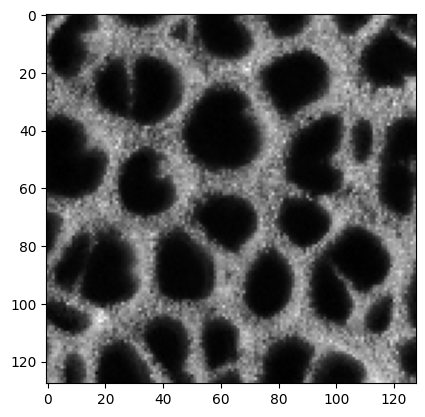

In [8]:
plt.imshow(X_train_secas_expanded[0],cmap='gray')
print(np.shape(X_train_secas_expanded[0]))
print(np.min(X_train_secas_expanded[0]),np.max(X_train_secas_expanded[0]))
plt.show()

In [ ]:
## Dataset de prueba
test_df = test_df.sample(frac=1,random_state=42).reset_index(drop=True)

X_test_secas = []
y_test_secas = []

nsize = 128

## Recorrerr rutas
for i in range(len(test_df)):
    
    #Capturar ruta y label
    ruta = test_df.iloc[i].routes
    label = test_df.iloc[i].label
    
    ##cargar imagen
    im = tf.keras.preprocessing.image.load_img(ruta,color_mode='grayscale')
    
    X_test_secas.append(tf.keras.preprocessing.image.img_to_array(im.resize((nsize,nsize))))
    y_test_secas.append(test_df.iloc[i].label)
    
print('Test: train->',np.shape(X_test_secas),' test ->',np.shape(y_test_secas))

In [ ]:
x_train_secas_expanded = np.array(X_train_secas_expanded)
x_test_secas = np.array(X_test_secas)

x_train_secas_expanded = x_train_secas_expanded.astype('float32')
x_test_secas= x_test_secas.astype('float32')
 
y_test_secas = tf.keras.utils.to_categorical(y_test_secas)
#y_train_expanded = tf.keras.utils.to_categorical(y_train_expanded) 

#x_train_expanded /= 255
x_test_secas /= 255

print('x_train shape:', x_train_secas_expanded.shape)
print('Number of images in x_train', x_train_secas_expanded.shape[0], "y_train:", np.shape(y_train_secas_expanded))
print('Number of images in x_test', x_test_secas.shape, "y_test: ", np.shape(y_test_secas))

## Modelo

### Autoencoder convencional

In [32]:
class encoder_block(layers.Layer):
    
    ## Inicializar la clase de capa convolucional
    def __init__(self,out_channels,kernel_size=3):
        ## conv y bn son las dos capas (que contienen pesos) del bloque/clase
        super(encoder_block, self).__init__()
        self.conv = layers.Conv2D(out_channels,kernel_size, padding='same')
        self.pooling = layers.MaxPooling2D()
        self.bn = layers.BatchNormalization()
    
    
    ## The call method is the same as the forward method of the block
    def call(self, input_tensor, training = False):
        x = self.conv(input_tensor)
        x = self.pooling(x)
        x = self.bn(x,training = training)   
        
        
        return x

class Encoder(keras.Model):
    
    def __init__(self,name = 'encoder',n_dims=128,**kwargs):
        super(Encoder, self).__init__(name=name, **kwargs)         
        ## Bloque convolucional:
        self.block1 = encoder_block(256)
        self.block2 = encoder_block(128)
        self.block3 = encoder_block(64)
        self.flattening = layers.Flatten()
        self.embedding = layers.Dense(n_dims,activation = 'relu')
        
        
    def call(self, tensor_input):
        block1 = self.block1(tensor_input)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        flat = self.flattening(block3)
        embs = self.embedding(flat)
        
        return embs
    

class decoder_block(layers.Layer):
    
    def __init__(self,out_channels,kernel_size=3):
        super(decoder_block,self).__init__()
        self.conv = layers.Conv2D(out_channels,kernel_size, padding='same')
        self.bn = layers.BatchNormalization()

        
    def call(self,input_tensor, training = False):
        x = self.conv(input_tensor)
        x = self.bn(x, training = training)
        
        return x
    
class Decoder(keras.Model):
    
    def __init__(self,name = 'decoder',**kwargs):
        super(Decoder, self).__init__(name=name, **kwargs)
        self.in_upsamp = layers.UpSampling2D(size=(2, 4), data_format=None, interpolation='nearest')
        self.upsamp = layers.UpSampling2D(size=(2, 2), data_format=None, interpolation='nearest')
        self.block1 = decoder_block(64)
        self.block2 = decoder_block(128)
        self.block3 = decoder_block(256)
        self.final = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')
        
        
    def call(self, embedding_input):
        embed = tf.reshape(embedding_input,[-1,16,8,1])
        x = self.in_upsamp(embed)
        x = self.block1(x)
        x = self.upsamp(x)
        x = self.block2(x)
        x = self.upsamp(x)
        x = self.block3(x)
        out = self.final(x)
        
        return out

class AE(keras.Model):
    def __init__(self,encoder,decoder, **kwargs):
        super(AE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name='total_loss')
        self.reconstruction_loss_tracker = keras.metrics.Mean(name='reconstruction_loss')
        
    @property
    def metrics(self):
        return[
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
        ]
    
    def train_step(self,data):
        with tf.GradientTape() as tape:
            ## Generar embebidos
            z = self.encoder(data)
            
            ## Reconstruir embebidos
            reconstruction = self.decoder(z)
            
            ## Normalizar reconstrucciones
            reconstruction /= tf.reduce_max(reconstruction)
            
            ## Calcular la diferencia binaria entre las imágenes de entrada y las reconstrucciones
            reconstruction_loss = tf.reduce_mean(
                    tf.reduce_sum(
                        keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                    )
                )
            
            ## Pérdida total
            total_loss = reconstruction_loss            
            
            ## Calcular los gradientes 
            grads = tape.gradient(total_loss, self.trainable_weights)           

            
            
            ## Guardar reconstrucciones en una variable propia del modelo
            self.reconstruction = reconstruction
            
            ## Calcular gradientes entre los pesos            
            self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
            
            ## Actualizar la variable de pérdida total
            self.total_loss_tracker.update_state(total_loss)
            
            ## Actualizar la variable de pérdida de reconstrucción
            self.reconstruction_loss_tracker.update_state(reconstruction_loss)       
            
            return {
                "loss": self.total_loss_tracker.result(),
                "reconstruction_loss": self.reconstruction_loss_tracker.result(),         
            }    

In [ ]:
enc = Encoder()
dec = Decoder()

vae = AE(enc, dec)
opt = tf.optimizers.Adam(learning_rate = 0.000001)
#nll = lambda x , rv_x: -rv_x.log_prob(x)
vae.compile(optimizer=opt)


vae.fit(x_train_secas_expanded, epochs=2000, 
                batch_size=16,
                         callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100)])

Epoch 1/2000


2023-09-18 00:10:16.465971: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-09-18 00:10:21.707476: W tensorflow/tsl/framework/bfc_allocator.cc:366] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.
2023-09-18 00:11:15.316641: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x1ba58c60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-18 00:11:15.316720: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA TITAN V, Compute Capability 7.0
2023-09

187/187 [==============================] - 176s 190ms/step - loss: 40868.6165 - reconstruction_loss: 35559.4961
Epoch 2/2000
187/187 [==============================] - 10s 55ms/step - loss: 25123.1038 - reconstruction_loss: 23131.3926
Epoch 3/2000
187/187 [==============================] - 10s 55ms/step - loss: 18272.5653 - reconstruction_loss: 17046.6992
Epoch 4/2000
187/187 [==============================] - 10s 55ms/step - loss: 14112.5806 - reconstruction_loss: 13335.2002
Epoch 5/2000
187/187 [==============================] - 10s 55ms/step - loss: 11676.9774 - reconstruction_loss: 11386.3057
Epoch 6/2000
187/187 [==============================] - 10s 55ms/step - loss: 10862.7453 - reconstruction_loss: 10806.5684
Epoch 7/2000
187/187 [==============================] - 10s 56ms/step - loss: 10719.3557 - reconstruction_loss: 10701.3271
Epoch 8/2000
187/187 [==============================] - 11s 57ms/step - loss: 10676.7416 - reconstruction_loss: 10663.6328
Epoch 9/2000
187/187 [=====

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



187/187 [==============================] - 11s 59ms/step - loss: 9743.0672 - reconstruction_loss: 9727.5771
Epoch 168/2000
187/187 [==============================] - 11s 59ms/step - loss: 9719.5750 - reconstruction_loss: 9725.7910
Epoch 169/2000
187/187 [==============================] - 11s 58ms/step - loss: 9727.9362 - reconstruction_loss: 9726.5508
Epoch 170/2000
187/187 [==============================] - 11s 59ms/step - loss: 9738.1891 - reconstruction_loss: 9723.8955
Epoch 171/2000
187/187 [==============================] - 11s 59ms/step - loss: 9711.6370 - reconstruction_loss: 9722.3945
Epoch 172/2000
187/187 [==============================] - 11s 58ms/step - loss: 9721.8812 - reconstruction_loss: 9721.4697
Epoch 173/2000
187/187 [==============================] - 11s 58ms/step - loss: 9721.2440 - reconstruction_loss: 9719.3398
Epoch 174/2000
187/187 [==============================] - 11s 58ms/step - loss: 9714.6567 - reconstruction_loss: 9717.2529
Epoch 175/2000
187/187 [=======

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



187/187 [==============================] - 11s 59ms/step - loss: 9670.3051 - reconstruction_loss: 9674.1426
Epoch 217/2000
187/187 [==============================] - 11s 58ms/step - loss: 9673.2969 - reconstruction_loss: 9672.8623
Epoch 218/2000
187/187 [==============================] - 11s 58ms/step - loss: 9671.2664 - reconstruction_loss: 9672.4434
Epoch 219/2000
187/187 [==============================] - 11s 59ms/step - loss: 9659.7547 - reconstruction_loss: 9671.5703
Epoch 220/2000
187/187 [==============================] - 11s 59ms/step - loss: 9679.8995 - reconstruction_loss: 9671.4844
Epoch 221/2000
187/187 [==============================] - 11s 59ms/step - loss: 9674.5276 - reconstruction_loss: 9670.0244
Epoch 222/2000
187/187 [==============================] - 11s 58ms/step - loss: 9664.6897 - reconstruction_loss: 9669.1729
Epoch 223/2000
187/187 [==============================] - 11s 58ms/step - loss: 9672.4808 - reconstruction_loss: 9667.7646
Epoch 224/2000
187/187 [=======

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



187/187 [==============================] - 11s 59ms/step - loss: 9644.4986 - reconstruction_loss: 9635.9414
Epoch 269/2000
187/187 [==============================] - 11s 59ms/step - loss: 9616.6613 - reconstruction_loss: 9637.4434
Epoch 270/2000
187/187 [==============================] - 11s 58ms/step - loss: 9629.9899 - reconstruction_loss: 9636.9121
Epoch 271/2000
187/187 [==============================] - 11s 58ms/step - loss: 9637.5425 - reconstruction_loss: 9636.1748
Epoch 272/2000
187/187 [==============================] - 11s 59ms/step - loss: 9630.8607 - reconstruction_loss: 9635.6289
Epoch 273/2000
187/187 [==============================] - 11s 59ms/step - loss: 9645.4962 - reconstruction_loss: 9634.2842
Epoch 274/2000
187/187 [==============================] - 11s 59ms/step - loss: 9637.9835 - reconstruction_loss: 9633.4668
Epoch 275/2000
187/187 [==============================] - 11s 59ms/step - loss: 9610.3200 - reconstruction_loss: 9632.7637
Epoch 276/2000
187/187 [=======

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



187/187 [==============================] - 11s 59ms/step - loss: 9620.9225 - reconstruction_loss: 9609.0518
Epoch 324/2000
187/187 [==============================] - 11s 59ms/step - loss: 9616.4810 - reconstruction_loss: 9609.7920
Epoch 325/2000
187/187 [==============================] - 11s 60ms/step - loss: 9609.2226 - reconstruction_loss: 9610.5264
Epoch 326/2000
187/187 [==============================] - 11s 58ms/step - loss: 9612.4264 - reconstruction_loss: 9608.4883
Epoch 327/2000
187/187 [==============================] - 11s 58ms/step - loss: 9603.5703 - reconstruction_loss: 9607.4443
Epoch 328/2000
187/187 [==============================] - 11s 58ms/step - loss: 9593.7718 - reconstruction_loss: 9608.5586
Epoch 329/2000
187/187 [==============================] - 11s 58ms/step - loss: 9599.0747 - reconstruction_loss: 9607.0498
Epoch 330/2000
187/187 [==============================] - 11s 59ms/step - loss: 9605.7082 - reconstruction_loss: 9609.7627
Epoch 331/2000
187/187 [=======

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



187/187 [==============================] - 11s 59ms/step - loss: 9611.6397 - reconstruction_loss: 9590.7324
Epoch 377/2000
187/187 [==============================] - 11s 59ms/step - loss: 9594.7058 - reconstruction_loss: 9590.8457
Epoch 378/2000
187/187 [==============================] - 11s 58ms/step - loss: 9592.6178 - reconstruction_loss: 9590.1475
Epoch 379/2000
187/187 [==============================] - 11s 58ms/step - loss: 9569.5953 - reconstruction_loss: 9590.7871
Epoch 380/2000
187/187 [==============================] - 11s 59ms/step - loss: 9584.9250 - reconstruction_loss: 9591.0547
Epoch 381/2000
187/187 [==============================] - 11s 58ms/step - loss: 9606.2328 - reconstruction_loss: 9590.2109
Epoch 382/2000
187/187 [==============================] - 11s 58ms/step - loss: 9579.2826 - reconstruction_loss: 9587.9717
Epoch 383/2000
187/187 [==============================] - 11s 59ms/step - loss: 9591.7451 - reconstruction_loss: 9589.4033
Epoch 384/2000
187/187 [=======

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



187/187 [==============================] - 11s 60ms/step - loss: 9561.9626 - reconstruction_loss: 9574.0742
Epoch 429/2000
187/187 [==============================] - 11s 59ms/step - loss: 9557.5732 - reconstruction_loss: 9575.0029
Epoch 430/2000
187/187 [==============================] - 11s 59ms/step - loss: 9580.0940 - reconstruction_loss: 9573.4590
Epoch 431/2000
187/187 [==============================] - 11s 58ms/step - loss: 9578.5959 - reconstruction_loss: 9573.3018
Epoch 432/2000
187/187 [==============================] - 11s 58ms/step - loss: 9587.0442 - reconstruction_loss: 9572.9531
Epoch 433/2000
187/187 [==============================] - 11s 59ms/step - loss: 9568.4520 - reconstruction_loss: 9572.3682
Epoch 434/2000
187/187 [==============================] - 11s 59ms/step - loss: 9574.4669 - reconstruction_loss: 9571.5518
Epoch 435/2000
187/187 [==============================] - 11s 58ms/step - loss: 9560.8233 - reconstruction_loss: 9571.0430
Epoch 436/2000
187/187 [=======

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



187/187 [==============================] - 11s 58ms/step - loss: 9564.8424 - reconstruction_loss: 9552.8672
Epoch 533/2000
187/187 [==============================] - 11s 58ms/step - loss: 9540.0395 - reconstruction_loss: 9551.1221
Epoch 534/2000
187/187 [==============================] - 11s 59ms/step - loss: 9559.1359 - reconstruction_loss: 9553.4287
Epoch 535/2000
187/187 [==============================] - 11s 59ms/step - loss: 9550.7634 - reconstruction_loss: 9552.2324
Epoch 536/2000
187/187 [==============================] - 11s 59ms/step - loss: 9560.3378 - reconstruction_loss: 9549.9121
Epoch 537/2000
187/187 [==============================] - 11s 59ms/step - loss: 9546.6323 - reconstruction_loss: 9550.6494
Epoch 538/2000
187/187 [==============================] - 11s 58ms/step - loss: 9551.7798 - reconstruction_loss: 9550.2979
Epoch 539/2000
187/187 [==============================] - 11s 58ms/step - loss: 9541.0628 - reconstruction_loss: 9551.5654
Epoch 540/2000
187/187 [=======

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



187/187 [==============================] - 11s 58ms/step - loss: 9542.7532 - reconstruction_loss: 9543.9902
Epoch 580/2000
187/187 [==============================] - 11s 59ms/step - loss: 9548.9822 - reconstruction_loss: 9544.1094
Epoch 581/2000
187/187 [==============================] - 11s 58ms/step - loss: 9531.4656 - reconstruction_loss: 9544.9541
Epoch 582/2000
187/187 [==============================] - 11s 59ms/step - loss: 9556.7474 - reconstruction_loss: 9543.9561
Epoch 583/2000
187/187 [==============================] - 11s 59ms/step - loss: 9536.7512 - reconstruction_loss: 9545.5479
Epoch 584/2000
187/187 [==============================] - 11s 58ms/step - loss: 9534.3331 - reconstruction_loss: 9546.4287
Epoch 585/2000
187/187 [==============================] - 11s 59ms/step - loss: 9556.2784 - reconstruction_loss: 9544.6855
Epoch 586/2000
187/187 [==============================] - 11s 58ms/step - loss: 9546.8398 - reconstruction_loss: 9544.0283
Epoch 587/2000
187/187 [=======

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



187/187 [==============================] - 11s 59ms/step - loss: 9524.5618 - reconstruction_loss: 9539.6592
Epoch 623/2000
187/187 [==============================] - 11s 59ms/step - loss: 9533.6730 - reconstruction_loss: 9540.2139
Epoch 624/2000
187/187 [==============================] - 11s 59ms/step - loss: 9531.8899 - reconstruction_loss: 9539.9824
Epoch 625/2000
187/187 [==============================] - 11s 58ms/step - loss: 9545.8681 - reconstruction_loss: 9537.7900
Epoch 626/2000
187/187 [==============================] - 11s 57ms/step - loss: 9545.4263 - reconstruction_loss: 9539.5586
Epoch 627/2000
187/187 [==============================] - 11s 59ms/step - loss: 9529.1142 - reconstruction_loss: 9537.3955
Epoch 628/2000
187/187 [==============================] - 11s 59ms/step - loss: 9547.2881 - reconstruction_loss: 9537.9668
Epoch 629/2000
187/187 [==============================] - 11s 59ms/step - loss: 9540.4416 - reconstruction_loss: 9538.0303
Epoch 630/2000
187/187 [=======

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



187/187 [==============================] - 11s 58ms/step - loss: 9544.0448 - reconstruction_loss: 9537.1602
Epoch 646/2000
187/187 [==============================] - 11s 59ms/step - loss: 9530.7390 - reconstruction_loss: 9535.9824
Epoch 647/2000
187/187 [==============================] - 11s 59ms/step - loss: 9536.0666 - reconstruction_loss: 9536.0469
Epoch 648/2000
187/187 [==============================] - 11s 59ms/step - loss: 9534.5210 - reconstruction_loss: 9537.0625
Epoch 649/2000
187/187 [==============================] - 11s 58ms/step - loss: 9547.4932 - reconstruction_loss: 9535.3174
Epoch 650/2000
187/187 [==============================] - 11s 59ms/step - loss: 9539.8045 - reconstruction_loss: 9535.1338
Epoch 651/2000
187/187 [==============================] - 11s 58ms/step - loss: 9548.6435 - reconstruction_loss: 9535.6553
Epoch 652/2000
187/187 [==============================] - 11s 59ms/step - loss: 9549.9150 - reconstruction_loss: 9534.9580
Epoch 653/2000
187/187 [=======

In [41]:
### Guardar modelo
vae.encoder.save('VAEs/models/subclassing_ae_encoder_dry_128',save_format="tf")
vae.decoder.save('VAEs/models/subclassing_ae_decoder_dry_128',save_format="tf")

INFO:tensorflow:Assets written to: VAEs/models/subclassing_ae_encoder_dry_128/assets


INFO:tensorflow:Assets written to: VAEs/models/subclassing_ae_encoder_dry_128/assets
2023-09-18 15:06:14.039024: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,?]
	 [[{{node inputs}}]]
2023-09-18 15:06:14.209768: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,?]
	 [[{{node inputs}}]]
2023-09-18 15:06:14.563783: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder 

INFO:tensorflow:Assets written to: VAEs/models/subclassing_ae_decoder_dry_128/assets


INFO:tensorflow:Assets written to: VAEs/models/subclassing_ae_decoder_dry_128/assets


In [46]:
ae_encoder = keras.models.load_model('VAEs/models/subclassing_ae_encoder_dry_128')
ae_decoder = keras.models.load_model('VAEs/models/subclassing_ae_decoder_dry_128')

In [ ]:
tipo = 'secas'
if tipo == 'secas': 
    print('Dataset secas')
    data_train = x_train_secas_expanded
    data_test = x_test_secas

    label_train = y_train_secas_expanded
    label_test = y_test_secas
else:
    print('Dataset humedas')
    data_train = x_train_humedas
    data_test = x_test_humedas

    label_train = y_train_humedas
    label_test = y_test_humedas

In [ ]:
# Embebidos del encoder
encoder_embds  = ae_encoder.predict(data_train)
print('Shape_embs: ',np.shape(encoder_embds))

# Embebidos del encoder
encoder_embds_test  = ae_encoder.predict(data_test)
print('Shape_embs: ',np.shape(encoder_embds_test))

In [50]:
## Dimensiones
dmx = 16
dmy = 8

In [52]:
np.shape(encoder_embds)

(2990, 128)

In [54]:
autoencoder_imgs = ae_decoder.predict(encoder_embds)
print(np.shape(autoencoder_imgs),np.shape(encoder_embds))

2023-09-18 15:12:01.513477: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'embedding_input' with dtype float and shape [?,128]
	 [[{{node embedding_input}}]]


94/94 [==============================] - 3s 23ms/step
(2990, 128, 128, 1) (2990, 128)


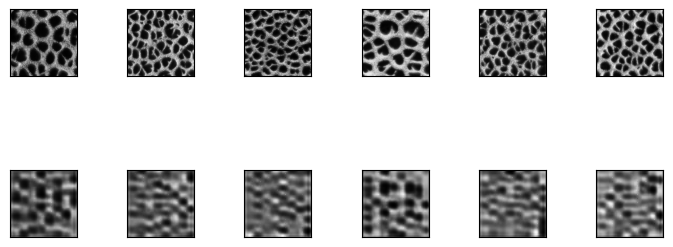

In [65]:
plt.figure(figsize=(30, 4))
for i in range(6):
    # display original
    ax = plt.subplot(4, 20, i + 1)
    plt.imshow(data_train[i].reshape(128,128,1))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)  
        
    # display reconstruction
    ax = plt.subplot(4, 20, 2*20 +i+ 1)
    plt.imshow(autoencoder_imgs[i].reshape(128,128,1))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)  
plt.show()